Using TensorFlow backend.


Tamaño de las muestras de entrenamiento ->  (10585, 100, 100, 3)
Tamaño de las etiquetas de entrenamiento ->  (10585,)
Hay 2381 muestras de entrenamiento pertenecientes a la clase 'mujer' (1)
Hay 8204 muestras de entrenamiento pertenecientes a la clase 'hombre' (0)
Un 0.2249 de las muestras de entrenamiento pertenecen a la clase 'mujer' (0)
Tamaño de las muestras de test ->  (2648, 100, 100, 3)
Tamaño de las etiquetas de test ->  (2648,)
Hay 596 muestras de test pertenecientes a la clase 'mujer' (1)
Hay 2052 muestras de test pertenecientes a la clase 'hombre' (0)
Un 0.2251 de las muestras de test pertenecen a la clase 'mujer' (0)


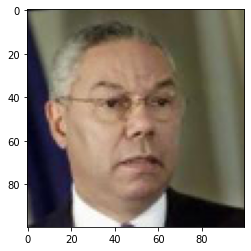

(10585, 100, 100, 3)
(2648, 100, 100, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 50, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 50, 50, 32)   0           batch_normalization_1[0][0]      
___________________________________________________

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import models
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
import os

os.system('wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz')
os.system('tar xvzf gender.tgz')

# Cargamos los datos
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Estadísticas
print("Tamaño de las muestras de entrenamiento -> ", x_train.shape)
print("Tamaño de las etiquetas de entrenamiento -> ", y_train.shape)
print("Hay %d muestras de entrenamiento pertenecientes a la clase 'mujer' (1)" % (sum(y_train == 1)))
print("Hay %d muestras de entrenamiento pertenecientes a la clase 'hombre' (0)" % (sum(y_train == 0)))
print("Un %s de las muestras de entrenamiento pertenecen a la clase 'mujer' (0)" % ("{:.4f}".format(sum(y_train == 1)/y_train.shape[0])))
print("Tamaño de las muestras de test -> ", x_test.shape)
print("Tamaño de las etiquetas de test -> ", y_test.shape)
print("Hay %d muestras de test pertenecientes a la clase 'mujer' (1)" % (sum(y_test == 1)))
print("Hay %d muestras de test pertenecientes a la clase 'hombre' (0)" % (sum(y_test == 0)))
print("Un %s de las muestras de test pertenecen a la clase 'mujer' (0)" % ("{:.4f}".format(sum(y_test == 1)/y_test.shape[0])))


## Vemos algunas imágenes
plt.imshow(x_train[0,:,:,: ] )
plt.show()


## Transformaciones
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)


num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Definimos un Data Augmentation Generator

datagen = ImageDataGenerator(
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)

datagen.fit(x_train)

## Definimos la estructura de nuestra ResNet

def convo_block(y, filtros, num_conv, res=0):
  
  if(res):
    x=y
  
  s = 2

  for i in range(num_conv):
    y=layers.Conv2D(filtros, kernel_size=(3, 3), strides=(s,s), padding='same')(y)
    s = 1
    y=layers.BatchNormalization()(y)
    y=layers.GaussianNoise(0.3)(y)
    if (i<num_conv-1):
      y=layers.ReLU()(y)

  if (res):
    x=layers.Conv2D(filtros, kernel_size=(1, 1), strides=(2,2),padding='same')(x)
    y=layers.add([x, y])
    y=layers.ReLU()(y)
  else:
    y=layers.MaxPooling2D(pool_size=(2, 2))(y)
        
  return y

def generate_model(sizeH, sizeW, num_classes, num_conv_blocks, fully_depth):
  shape=(sizeH,sizeW,3)
  filtros = 32
  n_conv = 1

  #Parte convolucional
  for i in range(num_conv_blocks):
    if (i==0):
      input_layer = layers.Input(shape=shape)
      x = convo_block(input_layer, filtros, n_conv)
    else:
      x = convo_block(x, filtros, n_conv, res=1)
      n_conv = n_conv * 2
      if filtros < 256:
          filtros = filtros * 2
  
  x=layers.Flatten()(x)

  #Parte fully connected
  for i in range(fully_depth):
    x=layers.Dense(512)(x)
    x=layers.BatchNormalization()(x)
    x=layers.GaussianNoise(0.3)(x)
    x=layers.ReLU()(x)
  
  x=layers.Dense(num_classes, activation='softmax')(x)
  model = models.Model(inputs=[input_layer], outputs=[x])

  return model

model = generate_model(100, 100, 2, 4, 1)
model.summary()

## Optimización y compilación
opt = SGD(lr=0.1, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Definimos un planificador para el learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1,
                              patience=10, min_lr=0.005)

## Entrenamos con Data Augmentation y Learning Rate Annealing
batch_size = 100
epochs = 200

history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[reduce_lr],
                            verbose=1)